# Determining the Ice thickness of Vatnajokull based on H/V spectral ratio

## Importing modules

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import datetime
from matplotlib import colors
import scipy

In [2]:
from obspy.signal import PPSD

In [3]:
import obspy

In [4]:
import os, sys
modules = os.path.abspath('Modules//')
if modules not in sys.path:
    sys.path.append(modules)

In [5]:
from normalize import normalize

## Functions

In [6]:
root = "D:\MEMOIRE\Ice_thickness"
alt_glacier = '\point_altitude_glacier\point_altitude_glacier.csv'
station = "\lt_nodes_ablation_lambert.csv"
hvsr_fold = "D:\MEMOIRE\Geopsy_res\DATE_7_12"

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [8]:
def distance_station(stt) :
    DIST_orign = [0]
    for i in range(1,len(stt)) :
        diff_X = float(stt[i][1]) - float(stt[i-1][1])
        diff_Y = float(stt[i][2]) - float(stt[i-1][2])
        dist = (diff_X**2+diff_Y**2)**(1/2)
        DIST_orign.append((DIST_orign[i-1]*1000+dist)/1000)
    return DIST_orign

### Importing the altitude surface of the glacier

In [9]:
with open(root+alt_glacier) as file :
    glac_alt = []
    pos = []
    line = 0
    readcsv = csv.reader(file, delimiter=',')
    for row in readcsv :
        if line > 0 :
            glac_alt.append(float(row[-1]))
            pos.append(float(row[3])/1000)
        line += 1
print(len(pos),len(glac_alt))

1430 1430


### Importing nodes altitudes

In [10]:
filepath = root+station
print(filepath)
with open(filepath) as file :
    stt = []
    readcsv = csv.reader(file, delimiter=',')
    i = 0
    line = 0
    for row in readcsv :
        if line > 0 :
            stt.append([row[1]])
            stt[i].extend(row[4:7])
            i += 1
        line += 1
        
def sortThird(val):
    return val[2]
stt.sort(key=sortThird)

node_alt = []
name_station = []
for line in stt :
    node_alt.append(float(line[3]))
    name_station.append(line[0])

print(len(node_alt))

D:\MEMOIRE\Ice_thickness\lt_nodes_ablation_lambert.csv
6


In [11]:
DIST = distance_station(stt)
#print(len(DIST))
print(DIST)

[0, 6.1713013104326855, 13.662399941999709, 20.884277112480284, 27.66827098849644, 33.389923544265464]


In [12]:
print(name_station)

['20773', '20781', '20769', '20774', '20739', '20754']


###### La oldest ice : Qu'est-ce que c'est ? partir sur où on la trouve, comment on la trouve et quel est l'intéret.

In [13]:
F0 = []
vs = 1900
H = []

YERRORHIGH = []
YERRORLOW = []
YERROR = []

FREQ = []
AMP_AVE = []

for nme_stt in name_station :   
    filepath = hvsr_fold+'\SS_'+ nme_stt +'.hv'
    print(filepath)
    line = 0
    with open(filepath) as file :
        tmpFREQ = []
        tmpAMP_AVE = []
        readcsv = csv.reader(file, delimiter='\t')
        for row in readcsv :
            line += 1
            if line == 5 :
                #print(row)
                f0 = float(row[1]) #extracting the f0 in the hv file
                #print(row[2])
                F0.append(f0)
                h = vs/(4.0*f0) #calculation of ice thickness
                H.append(h) #save ice thickness in a list
                yhigh = vs/(4.0*(float(row[3]))) #calculate the standart deviation of f0
                ylow = vs/(4.0*(float(row[2])))
                YERRORHIGH.append(h-yhigh)
                YERRORLOW.append(ylow-h)
            if line >= 10 and float(row[0]) >= 0.5  :
                tmpFREQ.append(float(row[0]))
                tmpAMP_AVE.append(float(row[1]))
    FREQ.append(np.array(tmpFREQ))
    AMP_AVE.append(np.array(tmpAMP_AVE))

FREQ = np.array(FREQ, dtype=object)
AMP_AVE = np.array(AMP_AVE, dtype=object)

BED_ALT = np.subtract(node_alt, H)
XERROR = ((vs/4)*np.power(F0, -1))/1000 #Lambda/4 where lambda = Vs/f0
#YERRORHIGH = 10*np.array(YERRORHIGH)
YERROR.append(YERRORLOW)
YERROR.append(YERRORHIGH)
#print(F0)
#print(H)
#print(BED_ALT)
#print(XERROR)
#print(YERROR)

D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20773.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20781.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20769.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20774.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20739.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20754.hv


### Plotting altitude based on Geopsy results

#### Plot version 1

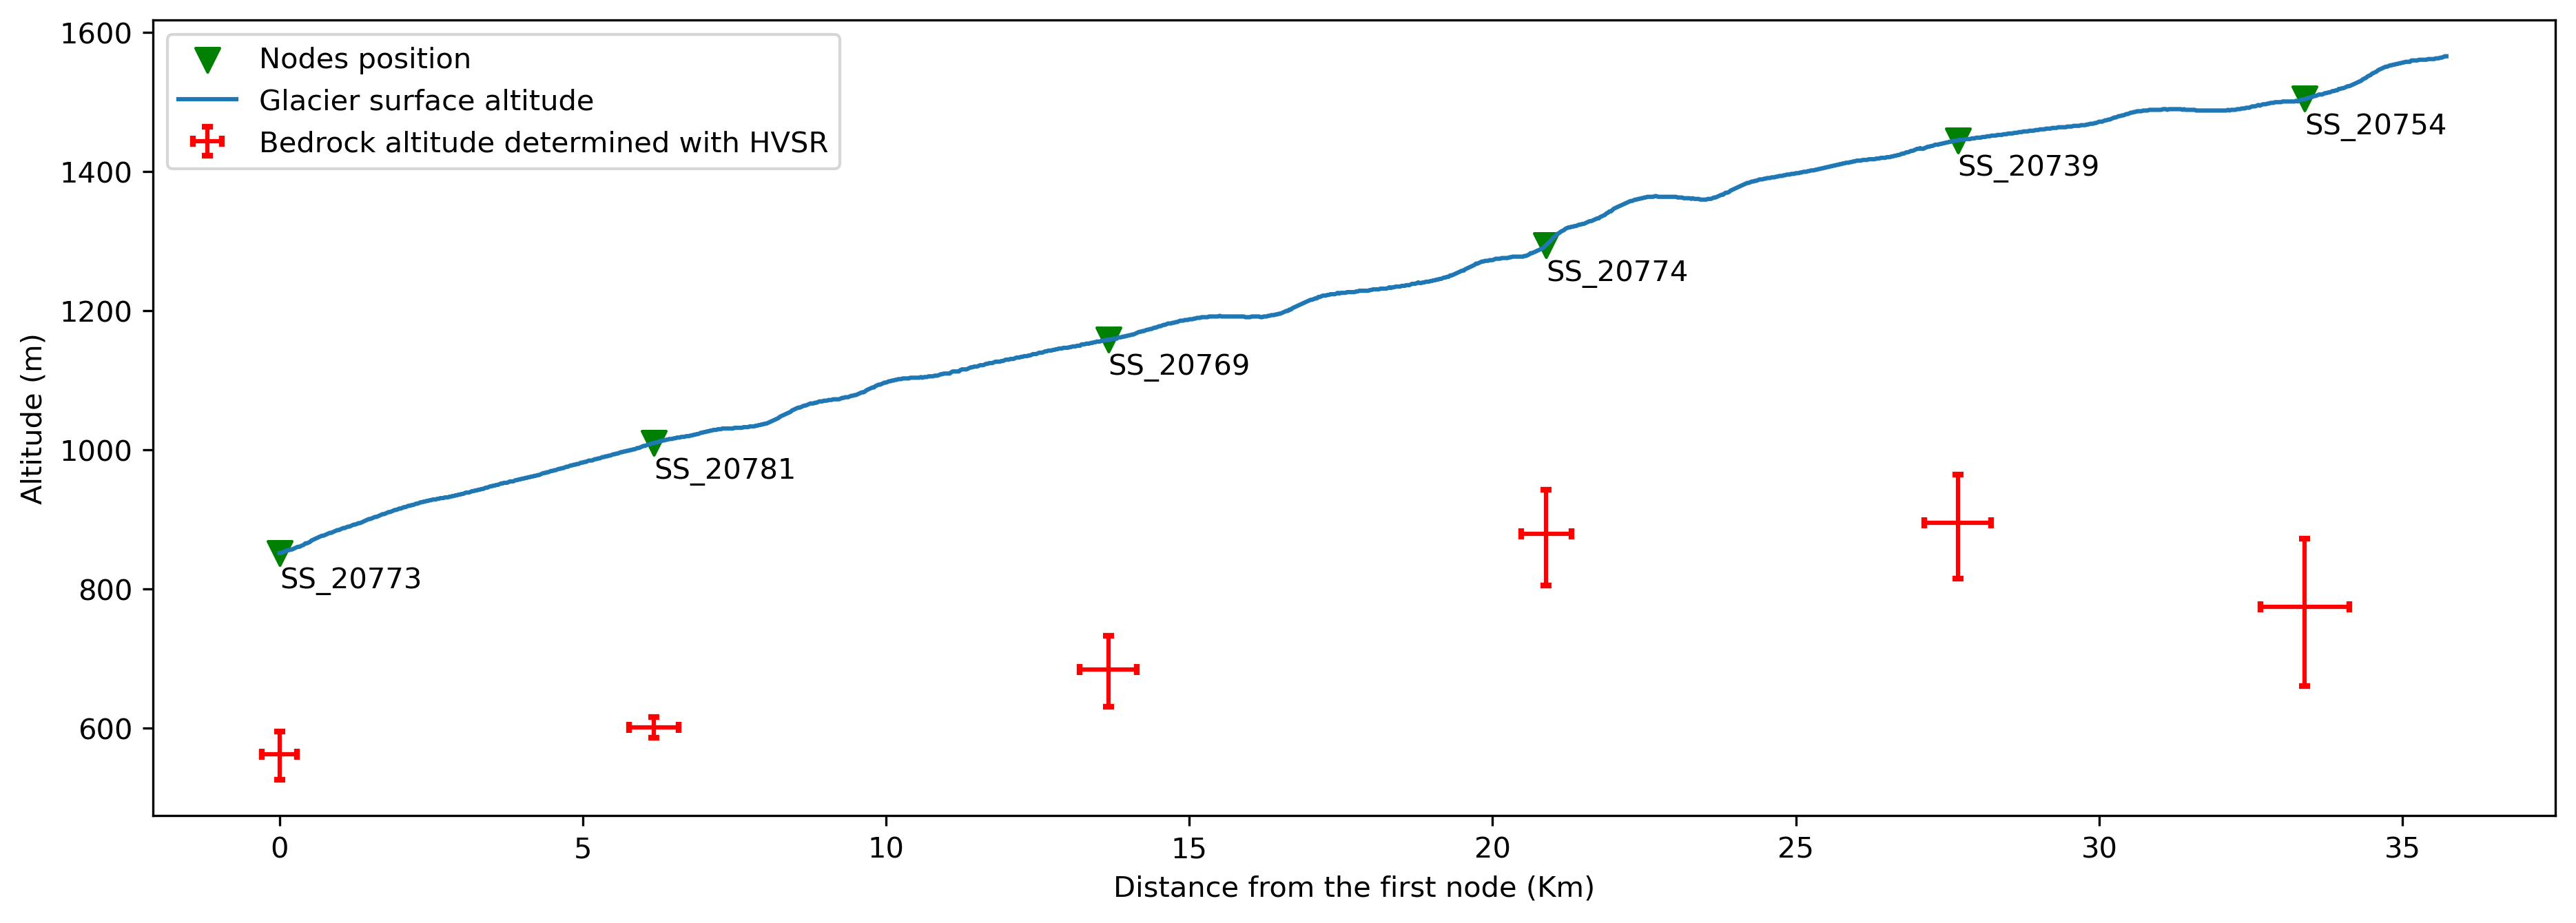

In [14]:
plt.figure(figsize=(15, 5), dpi=300)
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
#plt.scatter(DIST, BED_ALT, s=60, c='red',marker='o')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.savefig('plot_ice_thick/ice_thickness.png')
plt.show()

#### Plot version 2

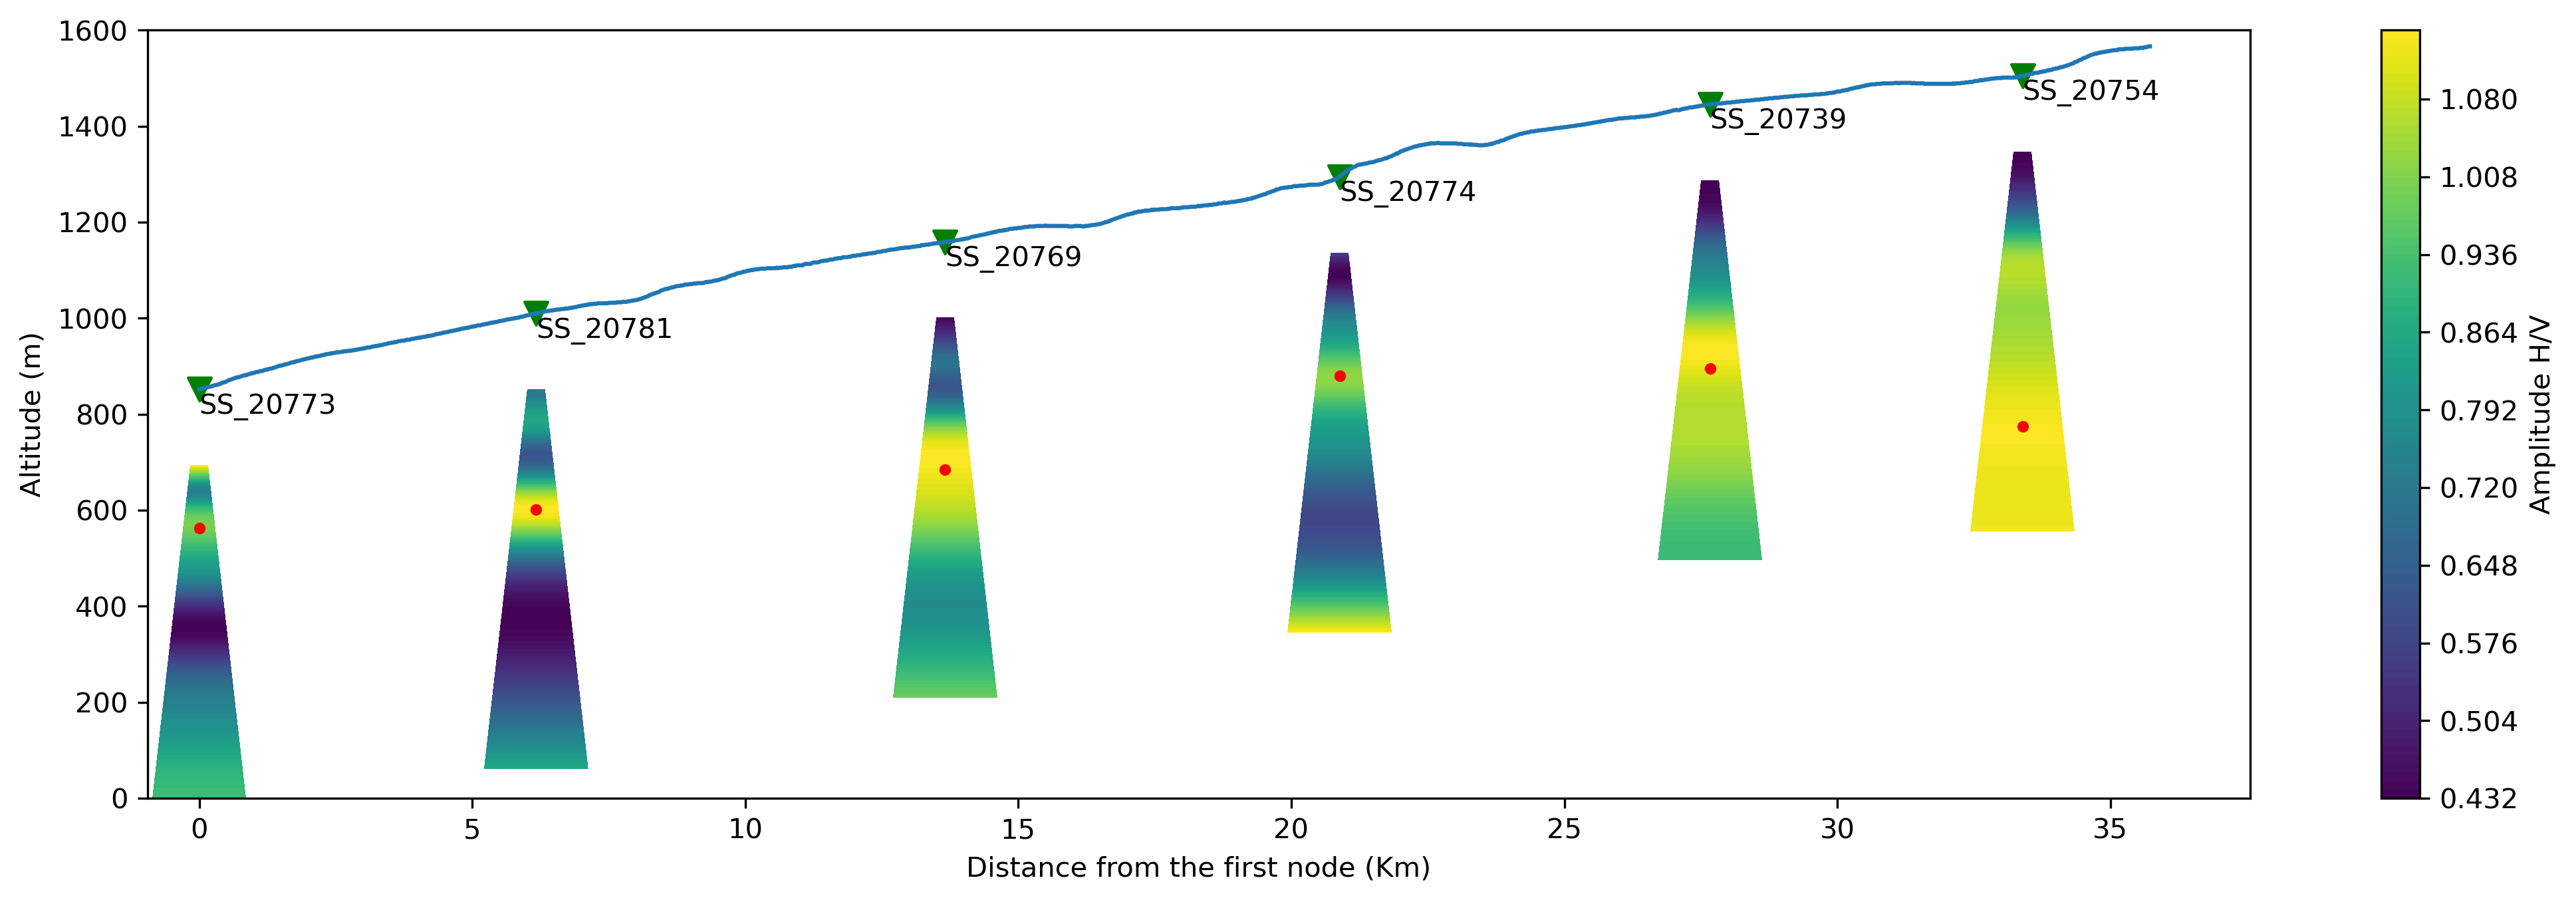

In [15]:
plt.figure(figsize=(17, 5), dpi=300)

for i in range(len(FREQ)) :
    L0 = [DIST[i]]*len(FREQ[i])
    L01 = L0 - ((vs/4)*np.power(FREQ[i], -1))/1000
    L1 = L0 + ((vs/4)*np.power(FREQ[i], -1))/1000
    L = []
    L.append(L01)
    L.append(L0)
    L.append(L1)
    L = np.array(L)
    
    HTOT = 1900/(4*np.array(FREQ[i]))
    HTOT = node_alt[i] - HTOT
    
    testFREQ = []
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ = np.array(testFREQ)

    testAMP = []
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP = np.array(testAMP)
    plt.ylim(0,1600)
    plt.contourf(L, testFREQ, testAMP, 100)
   
plt.colorbar(label = "Amplitude H/V")
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.scatter(DIST, BED_ALT, s=10, c='red',marker='o')
#plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.savefig('plot_ice_thick/HVintensity_ice_thickness.png')
plt.show()


### Comparing Ground-Penetrating radar - Continuous HVSR - Instantenous HVSR

#### Continuous HVSR

In [16]:
contiF0 = []
contiSTDF0 = []
contiXSTDF0 = []
for nodes in name_station :
    contiHV = pd.read_csv('./res_continuous_HVSR/%s/mean-hvsr-%s.csv' %(nodes,nodes))
    f0 = contiHV.f0[0]
    std = contiHV.stdf0[0]
    d = 1900/(4*f0)
    stdP = 1900/(4*f0+std)
    stdM = 1900/(4*f0-std)
    stdX = (1900/f0)/4
    contiF0.append(d)
    contiSTDF0.append([stdM-d,d-stdP])
    contiXSTDF0.append(stdX/1000) #transform in km
contiSTDF0 = np.array(contiSTDF0).transpose()
contiALT = np.array(node_alt) - np.array(contiF0)

In [17]:
node_alt

[852.0, 1010.0, 1159.0, 1294.0, 1445.0, 1505.0]

#### Ground-penetrating radar (Bjornsson et al, 2008)

In [18]:
gpr = pd.read_csv('D:/MEMOIRE/Ice_thickness/alti_gpr_finnur.csv',delimiter=';',decimal = ',')

In [19]:
gprpos = list(gpr['number'])
gprice = list(gpr['ice -thick'])
gprthick = []
for nodes in name_station :
    sttidx = gprpos.index(int(nodes))
    gprthick.append(gprice[sttidx])
gpralti = np.array(node_alt) - np.array(gprthick)
gprVerror = (1.68e8/5e6)/4

#### Plotting for the comparison

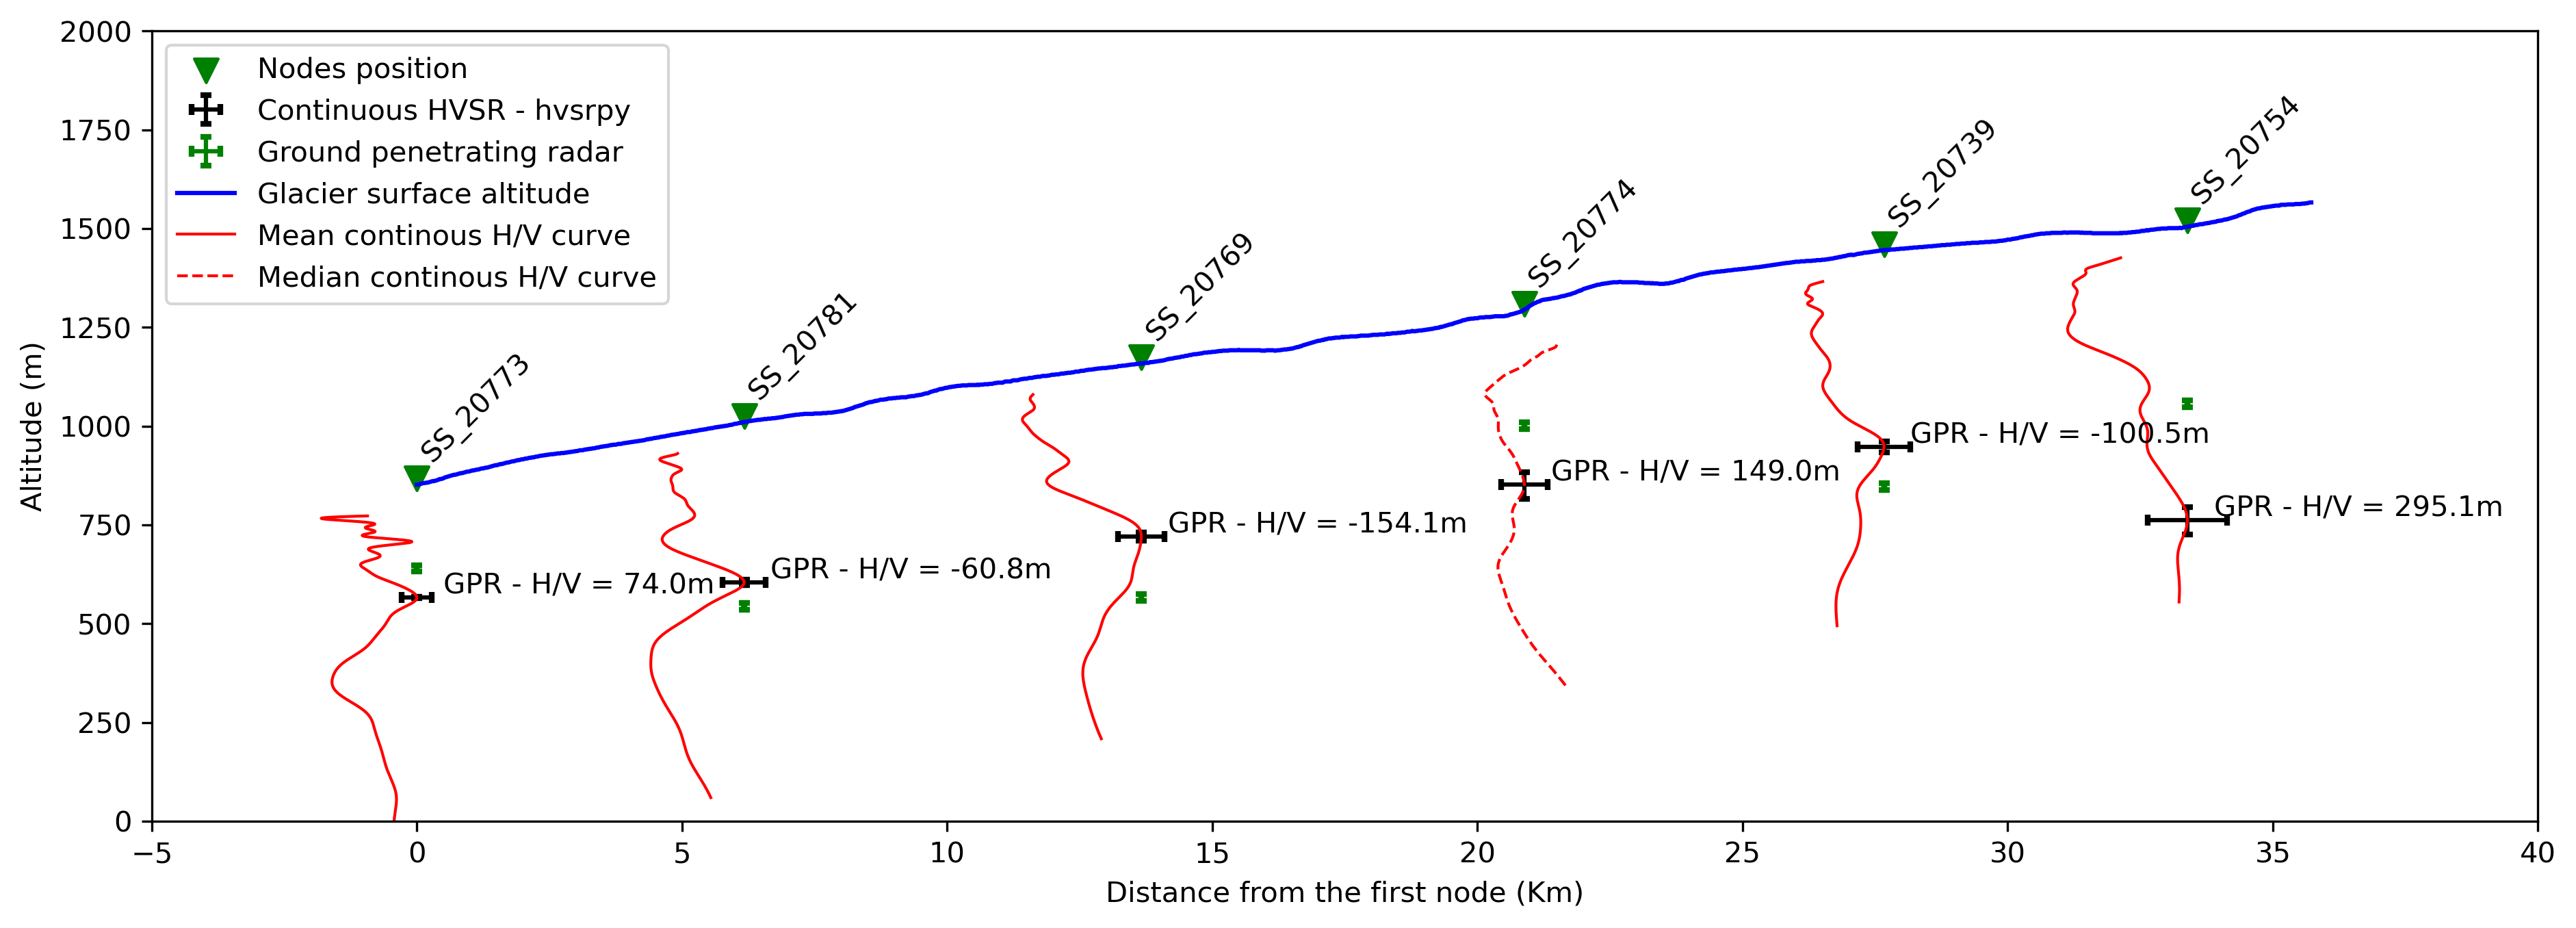

In [20]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
a1 = ax.scatter(DIST, np.array(node_alt)+15, s=70 , c='green', marker='v', label = 'Nodes position')
#plt.scatter(DIST, BED_ALT, s=60, c='red',marker='+', label='Instantenous HVSR - Geopsy')
a2 = ax.errorbar(DIST, contiALT, yerr = contiSTDF0, xerr = contiXSTDF0, linestyle='None', ecolor= 'k', capsize=2, capthick=2, label='Continuous HVSR - hvsrpy')
#plt.scatter(DIST, gpralti, s=60, c='green',marker='o', label='Ground penetrating radar')
a3 = ax.errorbar(DIST, gpralti, yerr = gprVerror, xerr = 1.5/1000, linestyle='None', ecolor= 'green', capsize=2, capthick=2, label='Ground penetrating radar')
a4, = ax.plot(pos, glac_alt, c='blue', label = 'Glacier surface altitude')
#plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for nodes in enumerate(name_station) :
    contiHV = pd.read_csv('./res_continuous_HVSR/%s/mean-hvsr-%s.csv' %(nodes[1],nodes[1]))
    dd = np.array(node_alt[nodes[0]]) - (1900/(4*contiHV.freq))
    idxf0 = list(contiHV.freq).index(contiHV.f0[0])
    aa = (contiHV['mean-amp'] - contiHV['mean-amp'][idxf0])*4 + DIST[nodes[0]]
    if nodes[1] == '20774':
        a6, = ax.plot(aa, dd, c='r', ls = '--', linewidth=1, label='Median continous H/V curve')
    else :
        a5, = ax.plot(aa, dd, c='r', linewidth=1, label='Mean continous H/V curve')
    plt.text(DIST[nodes[0]]+.5, contiALT[nodes[0]]+10, 'GPR - H/V = %.1fm' %(gpralti[nodes[0]] - contiALT[nodes[0]]))
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]+60,'SS_'+name_station[i], rotation= 45)
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.ylim(0, 2000)
plt.xlim(-5, 40)
ax.legend(handles=[a1, a2,a3,a4, a5, a6])
plt.savefig('./plot_ice_thick/compar-GPR/ice_thickness-compar.png', bbox_inches='tight')
plt.show()

# Automated continuous HVSR computing with hvsrpy module

Credit : https://github.com/jpvantassel/hvsrpy/blob/main/examples/simple_hvsrpy_interface.ipynb

## Importing modules and libraries

In [ ]:
import hvsrpy
import obspy
import time
import datetime
import sigpropy

## Functions

In [ ]:
def hvsr_export(filename, fields, ROW) :
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(fields) 

        # writing the data rows 
        csvwriter.writerows(ROW)

In [43]:
def hv_maximum(sensor, windowlenght, f_min, f_max, method = "squared-average",  azi=None) :
    
    ####### Rejection part #######
    
    n = 2 #standart deviation
    max_iterations = 50 #maximum interations to reject
    
    # Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
    distribution_f0 = "normal"
    
    distribution_mc = 'normal'#"lognormal"
    
    ###### cosine taper and konno and Ohmachi part ######
    
    width = 0.1 #Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    bandwidth = 40 # Konno and Ohmachi smoothing constant

    ###### filter part ######
    
    # Boolean to control whether Butterworth filter is applied. 
    # Geopsy does not apply a bandpass filter.
    filter_bool = False        
    # Low-cut frequency for bandpass filter.
    filter_flow = 0.1                   
    # High-cut frequency for bandpass filter.
    filter_fhigh = 30                   
    # Filter order.
    filter_order = 5
    bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}

    ###### resampling part ######
    
    # Minimum frequency after resampling
    resample_fmin = f_min   
    # Maximum frequency after resampling
    resample_fmax = f_max
    # Number of frequencies after resampling
    resample_fnum = 800
    # Type of resampling {'log', 'linear'}
    resample_type = 'log'

    resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
    
    ##### upper and lower frequency limits ######
    
    # Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
    peak_f_lower = f_min
    peak_f_upper = f_max
    # Geopsy's default is "squared-average" -> "geometric-mean" is recommended/// single-azimuth.
    
    ##### azimuthal part activation ######
    
    # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    
    if method == "squared-average" or "geometric-mean" : 
        #'single-azimuth' 
        azimuth = 0
    elif method == 'single-azimuth' or "multiple-azimuths"  :
        azimuth = azi

    #### making the hvsr computation #####
    
    hv = sensor.hv(windowlenght, bp_filter, width, 40, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)

    #max_freq = hv.mc_peak_frq(distribution_mc)
    #print(max_freq)
    
    #### making the hvsr rejection : Cox et al. 2020 #####
    
    #hv.reject_windows(n=n, max_iterations=max_iterations, distribution_f0=distribution_f0, distribution_mc=distribution_mc)

    #max_amp = hv.mc_peak_amp(distribution_mc)
    frq = hv.frq
    if method == "squared-average" or "geometric-mean" or 'single-azimuth':
        meanamp = hv.mean_curve(distribution_mc)
        return meanamp, frq
    elif method == "multiple-azimuths"  :
        meanamp = hv.mean_curves(distribution = distribution_mc)
        azi = hv.azimuths
        return meanamp, frq, azi


In [23]:
def plot_rotate(AZIFRQ, AZI, AZIAMP, STATION) :      
    AZIFRQ = np.array(AZIFRQ)
    AZIAMP = np.array(AZIAMP)
    AZI = np.array(AZI)
    
    frq = AZIFRQ[0]
    
    ind = np.unravel_index(np.argmax(AZIAMP, axis=None), AZIAMP.shape)
    a0 = np.max(AZIAMP, axis=None)

    plt.contourf(AZIFRQ,AZI,AZIAMP,30)
    plt.xlabel('frequency(Hz)')
    plt.ylabel('Azimuth (°)')
    cbar = plt.colorbar(label='Amplitude')
    plt.scatter(frq[ind[1]],AZI[ind[0]][0],c='r',marker='+')
    plt.xscale('log')
    title = 'Seismic station : '+STATION+'\n'+'f0 = '+str(frq[ind[1]])+' , A0 = ' +str(a0)+' , Azimuth = ' +str(AZI[ind[0]][0])+'°'
    plt.title(title)

## Ice thickness from hvsrpy

In [21]:
direct = 'D:\\MEMOIRE\\Geopsy_res\\d07m05h19h24hz05hz6\\compar\\'
stt = 'SS_20773'
csvfrq = []
csvamp = []
csvazi = []

tempfrq = []
tempamp = []
tempazi = []

with open(direct+stt+'.hv.grid') as file :
    readcsv = csv.reader(file, delimiter=' ')
    line = 0
    
    for row in readcsv :
        if line == 1 :
            tempfrq.append(float(row[0]))
            tempazi.append(float(row[1]))
            tempamp.append(float(row[2]))
        elif line > 1 and float(row[0]) != tempfrq[0] :
            tempfrq.append(float(row[0]))
            tempazi.append(float(row[1]))
            tempamp.append(float(row[2]))
        elif line > 1 and float(row[0]) == tempfrq[0] :
            csvfrq.append(tempfrq)
            csvamp.append(tempamp)
            csvazi.append(tempazi)
            tempfrq = [float(row[0])]
            tempazi = [float(row[1])]
            tempamp = [float(row[2])]
            line = 1
            
        line += 1

        

In [ ]:
plot_rotate(csvfrq, csvazi, csvamp, '453020773')

In [ ]:
DIFFAMP = np.array(csvamp) - np.array(AZIAMP)
plot_rotate(csvfrq, csvazi, DIFFAMP, 'Geopsy - hvsrpy (453020773)')

## Continuous HVSR

### Computation of continuous HVSR and saving in CSV file

In [25]:
windowlenght = 60 #second
f_min = 0.5
f_max = 6

startdate = '2022.05.08'

startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')


HVFREQALL = []
HVAMPALL = []
HVTIMEALL = []

        
STATION = ['20739','20754','20769','20773','20774','20781']
#STATION = ['20736','20740','20742','20746','20750','20751','20753','20755','20756','20759','20760','20762','20768','20780']
k=0

#root = 'D:/Nodes_ablation_zone/All_comp_DP_/'
root = 'D:/Nodes_ablation_zone/All_comp_DP_/'
fileroot= os.listdir(root)

for namestt in STATION :
    namestt = namestt
    pdstop = pd.read_csv('./temp_pos_nodes/tilt_%s.csv'%namestt)
    stop = pdstop['treshold_tilt'][0]
    print(stop)
    HVFREQ = []
    HVAMP = []
    HVTIME = []
    #root = 'D:\\Nodes_ablation_zone\\All_comp_DP_\\'
    
    rootout = 'res_continuous_HVSR\\ROTATE\\'
    
    path = os.path.join(rootout, namestt+'\\')
    
    if os.path.exists(path) is False :
        os.mkdir(path)
        print("Directory '%s' created" %path)
    msg = 'Starting the processing for the station : '    
    print(msg+namestt)
    #daysloop = days[k] - startnumber
    
    for day in range(11) :
        
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        
        #permet de déterminer le format du fichier dans le dossier pour une station donnée
        for file in fileroot :
            if file.startswith('4530%s.'%namestt) and file.endswith('%s.E.miniseed' %(datetimeStr)) :
                traceE = obspy.read(root+file)
                #traceE.plot()
            elif file.startswith('4530%s.'%namestt) and file.endswith('%s.N.miniseed' %(datetimeStr)) :
                traceN = obspy.read(root+file)
            elif file.startswith('4530%s.'%namestt) and file.endswith('%s.Z.miniseed' %(datetimeStr)) :
                traceZ = obspy.read(root+file) 
        
        dt = traceZ[0].stats.delta
        
        starttrace = traceZ[0].stats.starttime
        
        timesize = 60 #minutes

        dtnbr = int(timesize*60/dt)
        
        nbr_timestep = int(24*60/timesize)
        

        print('Starting the time loop for day : "%s"' %day)
        startprocess = time.process_time() 

        for i in range(nbr_timestep) :
            
            #retourne la position du temps souhaité
            posstart = int(i*dtnbr)
            posend = int((i+1)*dtnbr+1)
            
            #donne les trois traces dans chaque direction avec le temps de départ et fin correspondant
            SigtraceE = sigpropy.TimeSeries(traceE[0].data[posstart:posend], dt)
            SigtraceN = sigpropy.TimeSeries(traceN[0].data[posstart:posend], dt)
            SigtraceZ = sigpropy.TimeSeries(traceZ[0].data[posstart:posend], dt)
            
            #aggrège les inputs pour hvsrpy
            sensor = hvsrpy.Sensor3c(SigtraceN,SigtraceE,SigtraceZ)

            starttime = starttrace+i*timesize*60
            endtime = starttime+timesize*60
            
            if starttime > stop :
                break
            #print([starttime, endtime])
            azi = list(range(0,180,5))
            meanamp, frq, azi = hv_maximum(sensor, windowlenght, f_min, f_max, method="multiple-azimuths", azi=azi )
            
            #nom utilisé pour le fichier
            name = str(namestt)+'.'+str(day)+'.'+str(i)+'.csv'
        
            #Conversion du temps indiqué en string            
            starttime = datetime.datetime.strptime(str(starttime), '%Y-%m-%dT%H:%M:%S.000000Z') 
            endtime = datetime.datetime.strptime(str(endtime), '%Y-%m-%dT%H:%M:%S.000000Z')
            
            filename = path+name
            headers = ['FREQ','AMP','starttime','endtime']
            ROW = []
            print
            for j in range(len(frq)) :
                ROW.append([frq[j],meanamp[j],starttime, endtime])
            hvsr_export(filename, headers, ROW)
        endprocess = time.process_time()
        print('Processing accomplished in '+str(endprocess-startprocess)+' seconds')
    k += 1

### Loading continuous HVSR from saved data in a CSV file

In [22]:
def hvsr_reader(filename, filepath) :
        line = 0
        tmpfrq = []
        tmpamp = []
        tmptimedep = []
        tmptimeend = []
        with open(filepath) as file :
                readcsv = csv.reader(file, delimiter=',')
                for row in readcsv :
                    if line > 0 and row != [] :
                        tmpfrq.append(float(row[0]))
                        tmpamp.append(float(row[1]))
                        tmptimedep.append(datetime.datetime.strptime(str(row[2]),'%Y-%m-%d %H:%M:%S'))
                        tmptimeend.append(datetime.datetime.strptime(str(row[3]),'%Y-%m-%d %H:%M:%S'))
                        strtimedep = str(row[2]).replace(' ', 'T').replace('-', '_').replace(':', '_')
                        strtimeend = str(row[3]).replace(' ', 'T').replace('-', '_').replace(':', '_')
                    line += 1
        return tmpfrq, tmpamp, tmptimedep, tmptimeend, strtimedep, strtimeend

In [89]:
STATION = ['20732','20736','20740','20742','20746','20750','20751','20753','20755','20756','20759','20760','20762','20768','20780']

namestt = '4530'+ "20742" 
root = './res_continuous_HVSR/%s/' %namestt

ContiHVTime = []
ContiHVAmp = []
ContiHVNormAmp = []

miniplotfrq = []
miniplotamp = []
miniplottime = []
miniplotstrtime = []
miniplottimestart = []
miniplottimestartstr = []
miniplothour = []

startnbrdays = 0
nbrdays = 6 #days
timestep = 60 #minutes

nbrsteps = int(24*60/timestep)

for day in range(startnbrdays,nbrdays) :
    for i in range(nbrsteps) :
        filename = str(namestt)+'.'+str(day)+'.'+str(i)+'.csv'
        filepath = root+filename
        
        tmpfrq, tmpamp, tmptimedep, tmptimeend, strtimedep, strtimeend = hvsr_reader(filename, filepath)
        
        hour = timestep*i/60
        
        miniplotfrq.append(tmpfrq)
        miniplotamp.append(tmpamp)
        miniplottime.append([tmptimedep[0], tmptimeend[0]])
        miniplottimestart.append(tmptimedep[0])
        miniplottimestartstr.append(strtimedep)
        miniplotstrtime.append([strtimedep, strtimeend])
        
        miniplothour.append(hour) #permet de savoir si il y a une cyclicité journalière
        
        normamp = normalize(tmpamp)
        
        HTOT = 1900/(4*np.array(tmpfrq))
        
        ContiHVTime.append(tmptimedep[0]+datetime.timedelta(minutes=timestep/2))
        ContiHVAmp.append(tmpamp) 
        ContiHVNormAmp.append(normamp) 
        
    print('Jour : '+str(day))

Jour : 0
Jour : 1
Jour : 2
Jour : 3
Jour : 4
Jour : 5


### Continuous horizontal-to-vertical spectral ratio : plotting

108 799
0.02695958721219646


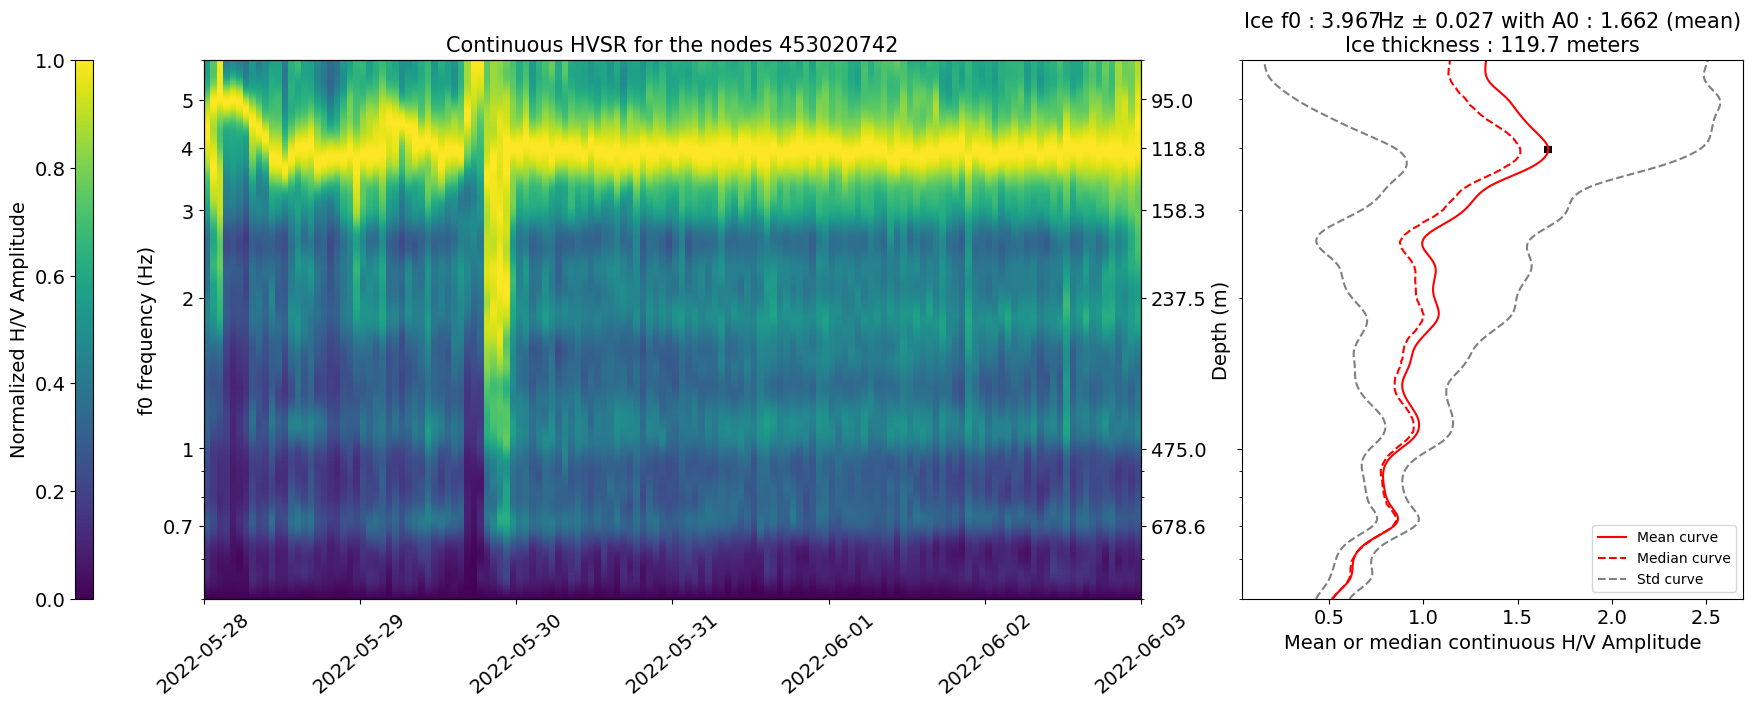

In [90]:
ContiHVTime = np.array(ContiHVTime)
ContiHVAmp = np.array(ContiHVAmp)
ContiHVNormAmp = np.array(ContiHVNormAmp)
if ContiHVNormAmp.shape[0] != 800 :
    ContiHVNormAmp = ContiHVNormAmp.transpose()
    ContiHVAmp = ContiHVAmp.transpose()
#ContiHVAmp = ContiHVNormAmp

contime, frq = np.meshgrid(ContiHVTime, tmpfrq)

fig = plt.figure(figsize=(22,7)) 
ax1 = plt.subplot2grid((1,3), (0,0), colspan=2)
norm = colors.Normalize(vmin=0,vmax=1.3)
cm =  ax1.pcolormesh(contime, frq,ContiHVNormAmp)#, norm=norm)

plt.title('Continuous HVSR for the nodes '+str(namestt), fontsize=15 )
ax1.set_yscale('log')
ax1.set_yticks([0.7,1,2,3,4,5])
ax1.set_yticklabels([0.7,1,2,3,4,5], fontsize=14)
ax1.set_ylabel('f0 frequency (Hz)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14, labelrotation=40)

ax2 = ax1.twinx()

ax2.set_ylabel('Depth (m)', fontsize=14)
ax2.set_ylim(.5,6)
depth = 1900/(4*np.array([0.7,1,2,3,4,5]))
ax2.plot(tmptimedep,tmpfrq, visible = False)
ax2.set_yscale('log')

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_yticks([0.7,1,2,3,4,5])
ax2.set_yticklabels([str(round(float(label), 1)) for label in depth], fontsize=14)

ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
ax3.set_ylim(.5,6)

minF = find_nearest(tmpfrq, .7)
maxF = find_nearest(tmpfrq, 6)
print(minF, maxF)
F0 = np.argmax(np.mean(ContiHVAmp, axis=1)[minF:maxF])
A0 = np.max(np.mean(ContiHVAmp, axis=1)[minF:maxF])

minstdF = find_nearest(tmpfrq, tmpfrq[minF+F0]-.5)
maxstdF = find_nearest(tmpfrq, tmpfrq[minF+F0]+.5)

stdANA = np.argmax(ContiHVAmp[minstdF:maxstdF,:], axis=0) #[minstdF:maxstdF,:]
tpofrq = []
for iF in stdANA :
    tpofrq.append(tmpfrq[iF])
stdFrq = np.std(tpofrq)
print(stdFrq)
ax3.errorbar(A0,tmpfrq[minF+F0],yerr = stdFrq, linestyle='None', ecolor= 'k', capsize=3, capthick=3)

#ax3.scatter(A0,tmpfrq[minF+F0],c='k',s=200, marker='+')

ax3.plot(np.mean(ContiHVAmp, axis=1),tmpfrq,c='r', label='Mean curve')
ax3.plot(np.median(ContiHVAmp, axis=1),tmpfrq, c='r', linestyle = '--', label='Median curve')
ax3.plot(np.mean(ContiHVAmp, axis=1)+np.std(ContiHVAmp, axis=1),tmpfrq, c='grey', linestyle = '--', label='Std curve')
ax3.plot(np.mean(ContiHVAmp, axis=1)-np.std(ContiHVAmp, axis=1),tmpfrq, c='grey', linestyle = '--')
f0thick = 1900/(4*tmpfrq[minF+F0])

ax3.set_yscale('log')
#ax3.set_xscale('log')
ax3.set_yticklabels([])
plt.title('Ice f0 : %.3fHz $\pm$ %.3f with A0 : %.3f (mean)\nIce thickness : %.1f meters' %(tmpfrq[minF+F0], stdFrq, A0, f0thick), fontsize=15)
plt.legend()
ax3.set_xlabel('Mean or median continuous H/V Amplitude', fontsize=14)
ax3.tick_params(labelsize=14)

cbar = fig.colorbar(cm,fraction = 0.05, aspect=30, location='left')
cbar.set_label(label = "Normalized H/V Amplitude",fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.savefig('plot_ice_thick/NODE_VATNA/UNNORM/continuous_HVintensity_b'+str(namestt)+'.png', bbox_inches='tight')    

plt.show()

### Saving continuous HVSR mean and median curve 

In [91]:
MeanCAmp = np.mean(np.array(ContiHVAmp), axis = 1)
MedCAmp = np.mean(np.array(ContiHVAmp), axis = 1)
STDCAmp = np.std(np.array(ContiHVAmp), axis = 1)
LF0 = np.full(MeanCAmp.shape,np.nan)
STDF0 = np.full(MeanCAmp.shape,np.nan)
LF0[0] = tmpfrq[minF+F0]
STDF0[0] = stdFrq
d = {'freq' : tmpfrq, 'mean-amp':MeanCAmp, 'median-amp':MedCAmp,'std-amp':STDCAmp,'f0':LF0,'stdf0':STDF0}
MMHvsr = pd.DataFrame(d)
file = './res_continuous_HVSR/%s/mean-hvsr-%s.csv' %(namestt,namestt)
MMHvsr.to_csv('./res_continuous_HVSR/%s/mean-hvsr-%s.csv' %(namestt,namestt))
print(file+' exported')

./res_continuous_HVSR/453020742/mean-hvsr-453020742.csv exported


In [92]:
MMHvsr

,freq,mean-amp,median-amp,std-amp,f0,stdf0
0,0.500000,0.518496,0.518496,0.089183,3.967462,0.02696
1,0.501557,0.520487,0.520487,0.089501,NaN,NaN
2,0.503120,0.522707,0.522707,0.089876,NaN,NaN
3,0.504687,0.525142,0.525142,0.090308,NaN,NaN
4,0.506259,0.527778,0.527778,0.090796,NaN,NaN
...,...,...,...,...,...,...
795,5.925822,1.331031,1.331031,1.175550,NaN,NaN
796,5.944280,1.331507,1.331507,1.176316,NaN,NaN
797,5.962796,1.332030,1.332030,1.177044,NaN,NaN
798,5.981369,1.332606,1.332606,1.177731,NaN,NaN


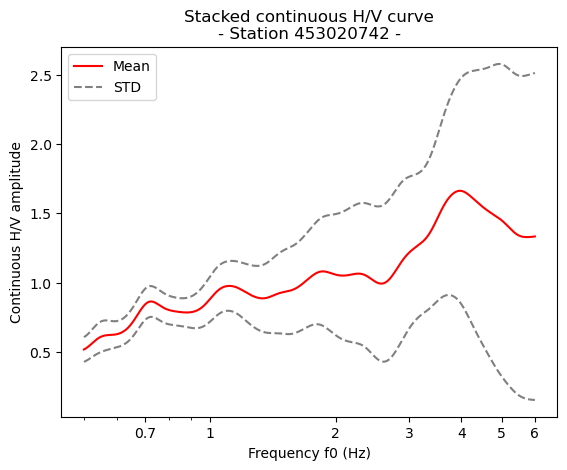

In [93]:
import istremor_hvsr as ist
ist.hvsr_TimePlot(tmpfrq, ContiHVAmp,namestt=namestt)

### Visualizing 1 hour

In [44]:
def hvsr_instantPlot(frq,amp, Tstart, namestt='N/A', dT = 1, ylimmin = None, ylimmax = None) :
    Tstart = Tstart - datetime.timedelta(minutes = 30)
    Tend = Tstart + datetime.timedelta(hours = 1)           
    plt.plot(frq, amp, c='red', label='Mean')
    plt.xscale('log')
    if ylimmin != None and ylimmax != None :
        plt.ylim(ylimmin,ylimmax)
    plt.xticks(ticks=[.7,1,2,3,4,5,6], labels=[.7,1,2,3,4,5,6])
    plt.xlabel('Frequency f0 (Hz)')
    plt.ylabel('H/V amplitude')
    plt.title('H/V curve\n- Station %s -\n%s - %s'%(namestt, Tstart, Tend))
    plt.legend()
    plt.show()
    

In [ ]:
hvsr_instantPlot(tmpfrq, ContiHVAmp[:,98], ContiHVTime[98], namestt= namestt)

### Analyses of the A0 variation at the fundamental resonance frequency of the ice

In [26]:
import netCDF4 as nc

def cdf_weather(data, lat, lon, start, end) :  
    #reading netcdf
    ds = nc.Dataset(data)
    #extracting data
    LON = list(ds['longitude'][:])
    LAT = list(ds['latitude'][:])
    u10 = np.array(ds['u10'][:])
    v10 = np.array(ds['v10'][:])
    prcp = np.array(ds['tp'][:])
    temp = np.array(ds['t2m'][:])
    smlt = np.array(ds['smlt'][:]) #m of water equivalent
    sf = np.array(ds['sf'][:])
    time = np.array(ds['time'][:])
    #converting time
    origin = datetime.datetime(1900,1,1)
    
    T = []
    PREP = []
    TEMP = []
    SMLT = []
    SF = []
    U10 = []
    V10 = []
    #finding the lat and lon
    idxLat = find_nearest(LAT, lat)
    idxLong = find_nearest(LON, lon)
    
    for h in enumerate(time) :
        t = origin + datetime.timedelta(hours = float(h[1]))
        if t > start and t < end :
            T.append(t)
            PREP.append(float(prcp[h[0]][idxLat][idxLong]))
            TEMP.append(float(temp[h[0]][idxLat][idxLong]))
            SMLT.append(float(smlt[h[0]][idxLat][idxLong]))
            SF.append(float(sf[h[0]][idxLat][idxLong]))
            U10.append(float(u10[h[0]][idxLat][idxLong]))
            V10.append(float(v10[h[0]][idxLat][idxLong]))
        elif t > end :
            break
    U10 = np.array(U10)
    V10 = np.array(V10)
    #print(U10, V10)
    W = np.sqrt(U10**2+V10**2)
    
    Wd = np.arctan(V10/U10)
    #quadran 1
    Wd = np.where(np.bitwise_and(V10 > 0, U10 > 0), np.abs(Wd-90), Wd)
    #quadran 2
    Wd = np.where(np.bitwise_and(V10 > 0, U10 < 0), np.abs(Wd+180-90), Wd)
    #quadran 3
    Wd = np.where(np.bitwise_and(V10 < 0, U10 < 0), np.abs(Wd+180-90), Wd)
    #quadran 4
    Wd = np.where(np.bitwise_and(V10 < 0, U10 > 0), np.abs(Wd+360-90), Wd)
    return T, PREP, TEMP, SMLT, SF, W, Wd

In [27]:
def mode_filter(rL, time,nbrpt = None) :
    rL = np.array(rL)
    if nbrpt == None :
        nbrpt = 8
    output = []
    T = []
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            mode = scipy.stats.mode(rL[i:i+nbrpt],keepdims=True)[0][0]
            output.append(mode)
            T.append(time[i])
    return np.array(output), T

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [29]:
def periodic_HV(ContiHVAmp,ContiHVTime,tmpfrq,F0) :
    idxFRQ = find_nearest(tmpfrq, F0)
    r = []
    R = []
    for i in range(len(ContiHVAmp[idxFRQ,:])) :
        if ContiHVTime[i].hour == 0 and i > 0 :
            R.append(np.array(r))
            r = []
        r.append(ContiHVAmp[idxFRQ,i])
    R = np.array(R)
    meanR = np.mean(R, axis=0)
    medianR = np.median(R, axis=0)
    stdR = np.std(R, axis=0)
    print(R.shape)
    return meanR, medianR, stdR

(5, 24)


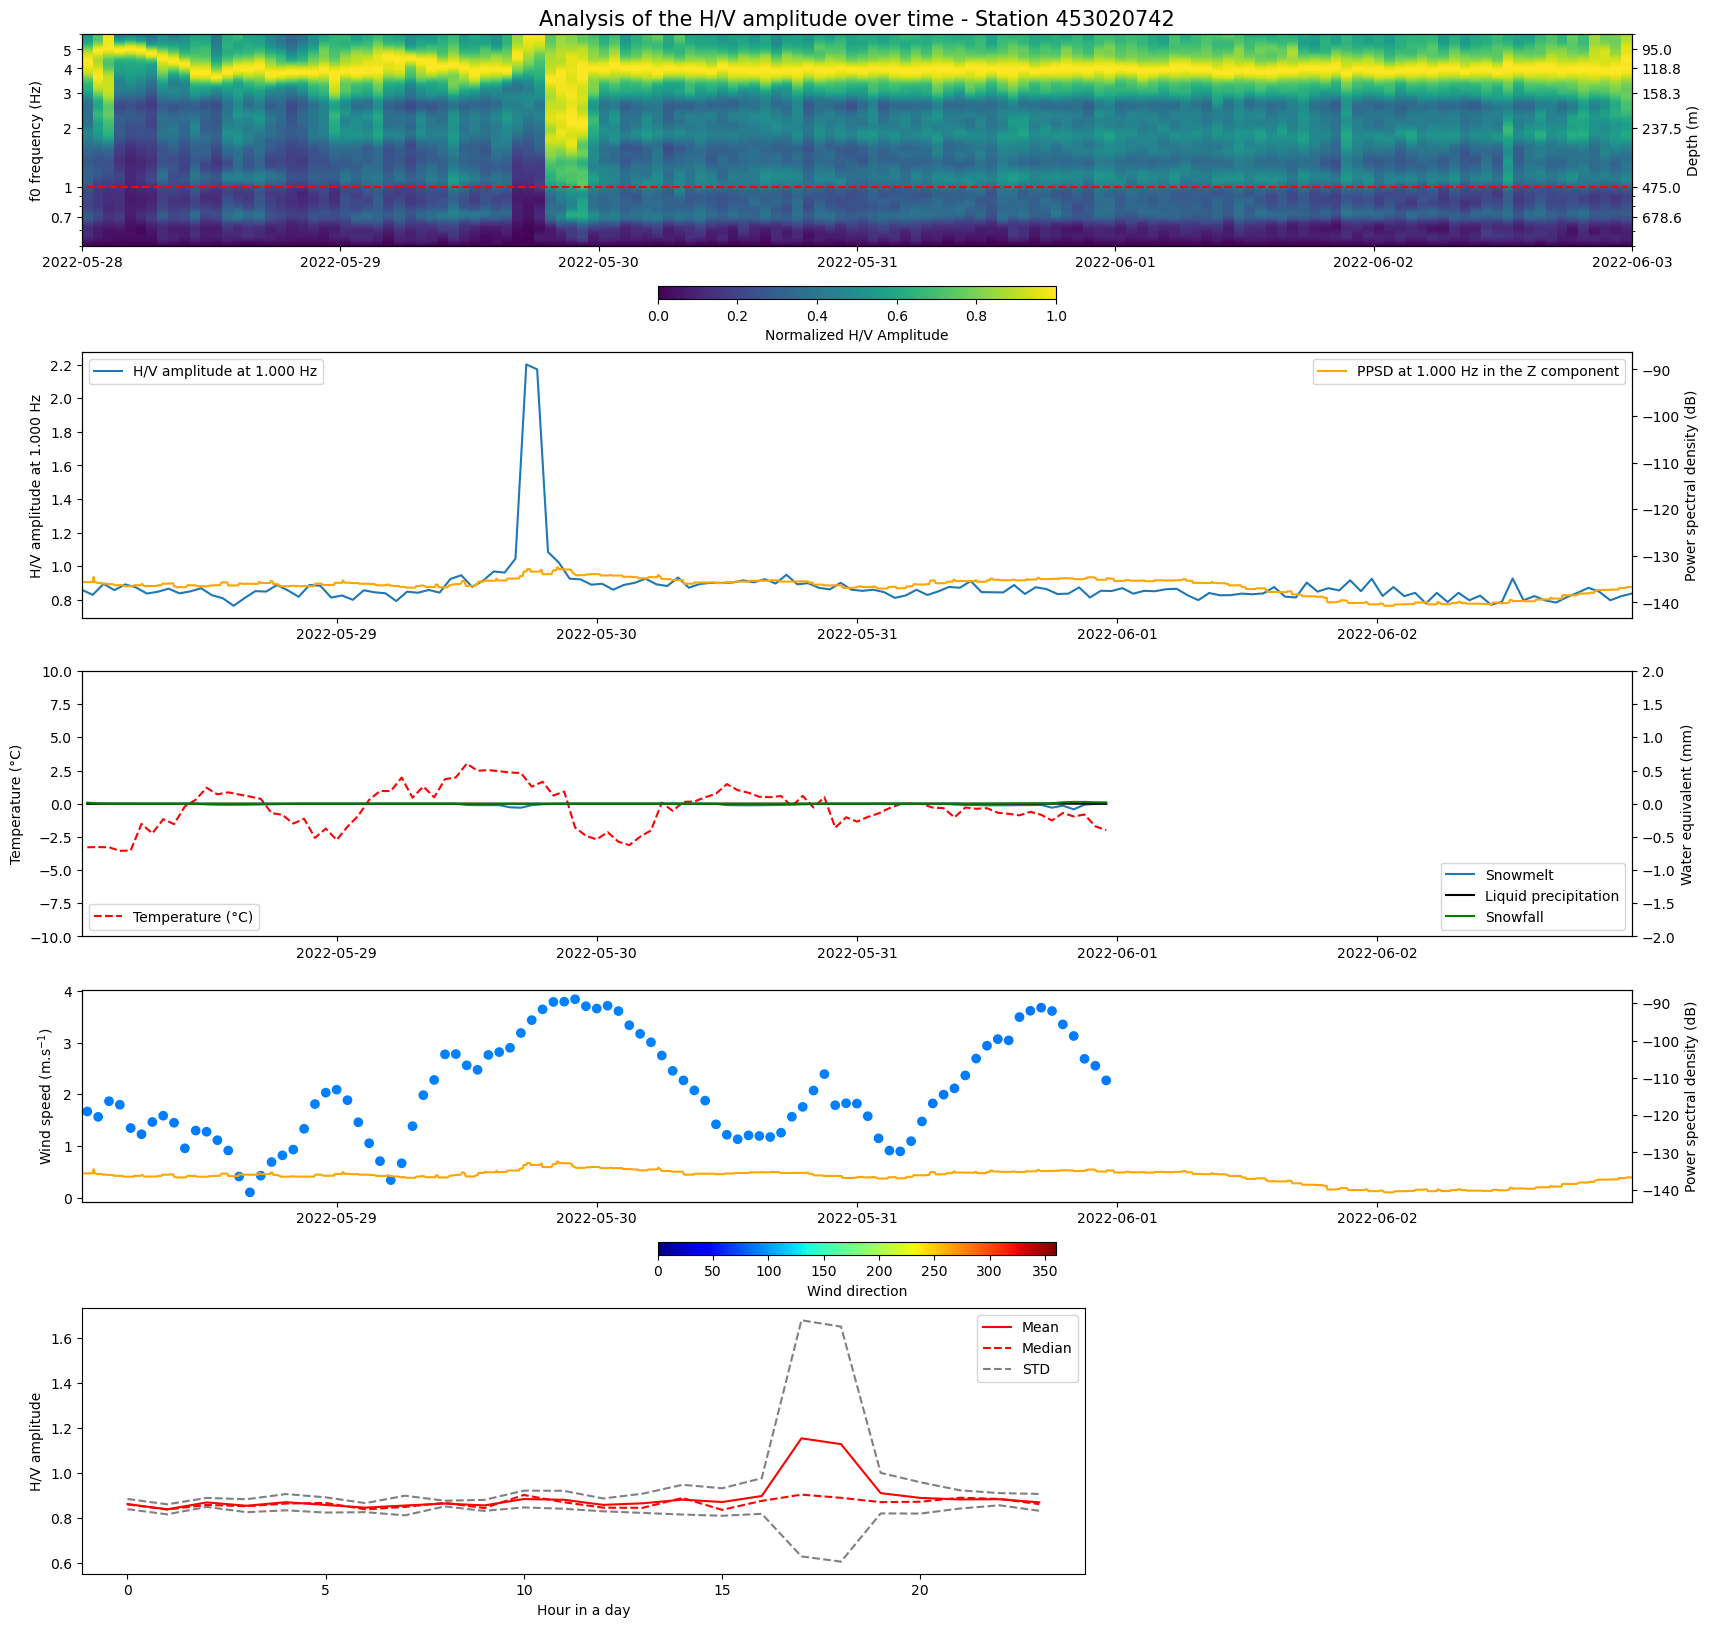

In [97]:
F0 =  1.0 #tmpfrq[minF+F0]


fig = plt.figure(figsize=(20,20))

### Need ContiHVNormAmp, ContiHVAmp, tmpfrq, ContiHVTime, F0

### Continuous HVSR part

ax1 = plt.subplot2grid((5,3), (0,0), colspan=3)
contime, frq = np.meshgrid(ContiHVTime, tmpfrq)
cm =  ax1.pcolormesh(contime, frq,ContiHVNormAmp)
ax1.set_yscale('log')
ax1.set_yticks([0.7,1,2,3,4,5])
ax1.set_yticklabels([0.7,1,2,3,4,5])
ax1.set_ylabel('f0 frequency (Hz)')
ax1.plot([ContiHVTime[0],ContiHVTime[-1]],[F0,F0], c='r',linestyle='--')
plt.colorbar(cm,orientation='horizontal',label = "Normalized H/V Amplitude",fraction = 0.05, aspect=30)

plt.title('Analysis of the H/V amplitude over time - Station %s' %namestt, fontsize=15)

ax2 = ax1.twinx()

ax2.set_ylabel('Depth (m)')
ax2.set_ylim(.5,6)
depth = 1900/(4*np.array([0.7,1,2,3,4,5]))
ax2.plot(tmptimedep,tmpfrq, visible = False)
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_yticks([0.7,1,2,3,4,5])
ax2.set_yticklabels(str(round(float(label), 1)) for label in depth)

ax3 = plt.subplot2grid((5,3), (1,0), colspan=3)

idxFRQ = find_nearest(tmpfrq, F0)

ax3.plot(ContiHVTime,ContiHVAmp[idxFRQ,:], label='H/V amplitude at %.3f Hz' %F0)
ax3.set_xlim(ContiHVTime[0],ContiHVTime[-1])
ax3.set_ylabel('H/V amplitude at %.3f Hz' %F0)
plt.legend(loc='upper left')
ax3b = ax3.twinx()

ppsd = PPSD.load_npz('./ppsd/nodes_vatna/%s_ppsdZ.npz'%namestt)
psd = ppsd.extract_psd_values(1/F0)[0]
Tpsd = ppsd.times_processed
fpsd, fTpsd = mode_filter(psd, Tpsd,nbrpt = 11)
ax3b.plot(np.array(fTpsd, dtype='datetime64[ms]'),fpsd, c='orange', label='PPSD at %.3f Hz in the Z component' %F0)
ax3b.set_ylabel('Power spectral density (dB)')
plt.legend(loc='upper right')

ax4 = plt.subplot2grid((5,3), (2,0), colspan=3)
data = './temp-precip/era5-island-wind.nc'
location = pd.read_csv('D:/MEMOIRE/SIG/Stations/vatna_nodes.csv', delimiter=';',decimal=',')
#namestt += '4530'
locstt = list(location.station).index(int(namestt))
lon = list(location.Xcoord)[locstt]
lat = list(location.Ycoord)[locstt] 
T, PREP, TEMP, SMLT, SF, W, Wd = cdf_weather(data, lat, lon, ContiHVTime[0], ContiHVTime[-1])
#ax4.text(.5, .5,'METEOOOOO')
ax4.plot(T,np.array(TEMP)-273.15, c='r', linestyle ='--', label='Temperature (°C)')
ax4.set_xlim(ContiHVTime[0],ContiHVTime[-1])
ax4.set_ylim(-10,10)
ax4.set_ylabel('Temperature (°C)')
plt.legend(loc='lower left')
ax4b = ax4.twinx()
ax4b.plot(T,np.array(SMLT)*-1000, label='Snowmelt')
ax4b.plot(T,np.array(PREP)*1000 - np.array(SF)*1000, c='k',label='Liquid precipitation')
ax4b.plot(T,np.array(SF)*1000, c='green',label='Snowfall')
ax4b.set_ylim(-2,2)
ax4b.set_ylabel('Water equivalent (mm)')
plt.legend(loc='lower right')

ax5 = plt.subplot2grid((5,3), (3,0), colspan=3)
norm = colors.Normalize(vmin=0,vmax=360)
wind = ax5.scatter(T,W, c=Wd,norm=norm, cmap='jet')
ax5.set_xlim(ContiHVTime[0],ContiHVTime[-1])
plt.colorbar(wind,orientation='horizontal',label = "Wind direction",fraction = 0.05, aspect=30)
ax5.set_ylabel('Wind speed (m.s$^{-1}$)')

ax5b = ax5.twinx()

ax5b.plot(np.array(fTpsd, dtype='datetime64[ms]'),fpsd, c='orange', label='PPSD at %.3f Hz in the Z component' %F0)
ax5b.set_ylabel('Power spectral density (dB)')

ax6 = plt.subplot2grid((5,3), (4,0), colspan=2)

meanCycle, medianCycle, stdCycle = periodic_HV(ContiHVAmp,ContiHVTime,tmpfrq,F0)
ax6.plot(list(range(24)),meanCycle, c='r', label='Mean') 
ax6.plot(list(range(24)),medianCycle, c='r', linestyle='--', label='Median')
ax6.plot(list(range(24)),meanCycle + stdCycle, c='grey', linestyle='--', label='STD')
ax6.plot(list(range(24)),meanCycle - stdCycle, c='grey', linestyle='--')
ax6.set_ylabel('H/V amplitude')
ax6.set_xlabel('Hour in a day')
plt.legend()
plt.savefig('./plot_ice_thick/hv_cycle/neo_ablation_%s_%.3f.jpeg' %(namestt,F0))
plt.show()


### Comparison with wind

In [33]:
import sklearn.linear_model as sk
def reg_inter(X,Y) :
    reg = sk.RANSACRegressor().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    Ypred =  reg.predict(X.reshape(-1, 1))
    R2 = reg.score(X.reshape(-1, 1), Y.reshape(-1, 1))
    c = reg.estimator_.coef_
    i = reg.estimator_.intercept_
    return Ypred, c, i, R2

In [34]:
Fw = 2.8
idxFRQ = find_nearest(tmpfrq, Fw)
WindAMP = ContiHVAmp[idxFRQ,:]

#### Comparison wind speed vs H/V amplitude

In [35]:
pred1, c1, i1, R21 = reg_inter(W,WindAMP[:-1])
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(W,WindAMP[:-1])
ax[0].plot(W,pred1, c='r', ls='--')
ax[0].text(4.5,1.6, 'R$^2$ = %.2f' %R21)
ax[0].text(4.5,1.5, 'y = %.2fx + %.2f' %(c1, i1))
ax[0].set_xlabel('Wind speed m.s$^{-1}$')
ax[0].set_ylabel('H/V Amplitude at %.2fHz' %Fw)
resi = pred1.reshape(1,-1)-WindAMP[:-1]
ax[1].scatter(pred1,resi)
ax[1].set_xlabel('Predicted values')
ax[1].set_ylabel('Predicted - H/V true values')

ValueError: Found input variables with inconsistent numbers of samples: [95, 113]

#### Comparison wind speed vsm.s$^{-1}$ PPSD

In [36]:
WTpsd = []
Wpsd = []
for a in enumerate(fTpsd) :
    if a[1].minute == 0 :
        WTpsd.append(a[1])
        Wpsd.append(fpsd[a[0]])
    if a[1] > ContiHVTime[-1] :
        break

In [37]:
pred2, c2, i2, R22 = reg_inter(W,np.array(Wpsd[:-1]))

plt.plot(W,pred2, c='r', ls='--')
plt.scatter(W, Wpsd[:-1])
plt.text(1,-128, 'R$^2$ = %.2f' %R22)
plt.text(1,-129, 'y = %.2fx + %.2f' %(c2, i2))
plt.xlabel('Wind speed m.s$^{-1}$')
plt.ylabel('PPSD (dB) in Z component at %.2fHz$' %Fw)

ValueError: Found input variables with inconsistent numbers of samples: [95, 113]

#### Comparison H/V amplitude vs PPSD

Text(0, 0.5, 'H/V Amplitude at 2.80Hz')

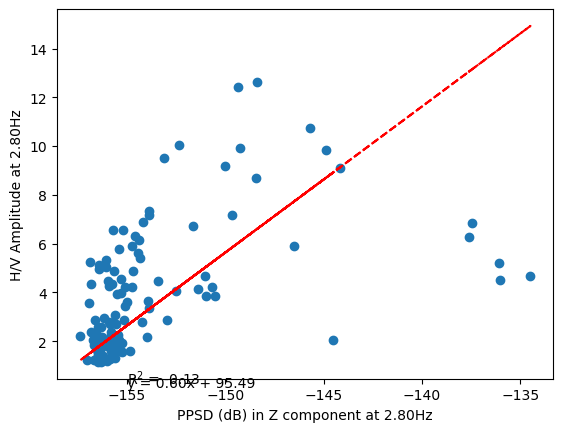

In [38]:
pred3, c3, i3, R23 = reg_inter(np.array(Wpsd),WindAMP)
plt.plot(Wpsd,pred3, c='r', ls='--')
plt.scatter(Wpsd,WindAMP)
plt.text(-155,0.25, 'R$^2$ = %.2f' %R23)
plt.text(-155,0.10, 'y = %.2fx + %.2f' %(c3, i3))
plt.xlabel('PPSD (dB) in Z component at %.2fHz' %Fw)
plt.ylabel('H/V Amplitude at %.2fHz' %Fw)

### Animated HVSR plot

In [ ]:
contime, frq = np.meshgrid(ContiHVTime, tmpfrq)

fig = plt.figure(figsize=(22,7)) 
ax1 = plt.subplot2grid((1,3), (0,0), colspan=2)
norm = colors.Normalize(vmin=0,vmax=1.3)
cm =  ax1.pcolormesh(contime, frq,ContiHVNormAmp)#, norm=norm)

plt.title('Continuous HVSR for the nodes %s\n' %(namestt), fontsize=15 )
ax1.set_yscale('log')
ax1.set_yticks([0.7,1,2,3,4,5])
ax1.set_yticklabels([0.7,1,2,3,4,5], fontsize=14)
ax1.set_ylabel('f0 frequency (Hz)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14, labelrotation=40)




cbar = fig.colorbar(cm,fraction = 0.05, aspect=30, location='left')
cbar.set_label(label = "Normalized H/V Amplitude",fontsize=14)
cbar.ax.tick_params(labelsize=14)




for i in range(len(ContiHVTime)) :
    t = ContiHVTime[i]-datetime.timedelta(minutes=30)
    plt.title('Continuous HVSR for the nodes %s\n%s - %s' %(namestt, str(t), str(t+datetime.timedelta(hours=1))), fontsize=15 )
    ax2 = ax1.twinx()

    ax2.set_ylabel('Depth (m)', fontsize=14)
    ax2.set_ylim(.5,6)
    ax2.plot([ContiHVTime[i],ContiHVTime[i]],[.5,6], c='r', ls='--')
    depth = 1900/(4*np.array([0.7,1,2,3,4,5]))
    ax2.plot(tmptimedep,tmpfrq, visible = False)
    ax2.set_yscale('log')

    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_yticks([0.7,1,2,3,4,5])
    ax2.set_yticklabels([str(round(float(label), 1)) for label in depth], fontsize=14)

    
    ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
    ax3.set_ylim(.5,6)

    #ax3.scatter(A0,tmpfrq[minF+F0],c='k',s=200, marker='+')
    ax3.plot(ContiHVAmp[:,i],tmpfrq,c='r', label='H/V curve')
    f0thick = 1900/(4*tmpfrq[minF+F0])

    ax3.set_yscale('log')
    #ax3.set_xscale('log')
    ax3.set_yticklabels([])
    ax3.set_xlim(.2,1.5)
    plt.scatter(ContiHVAmp[minF+F0,i],tmpfrq[minF+F0], c='k', s=70)
    plt.title('Ice f0 : %.3fHz $\pm$ %.3f with A0 : %.3f (mean)\nIce thickness : %.1f meters' %(tmpfrq[minF+F0], stdFrq, A0, f0thick), fontsize=15)
    ax3.set_xlabel('Continuous H/V Amplitude', fontsize=14)
    ax3.tick_params(labelsize=14)



    plt.savefig('images_hvsr_gif/453020739/continuous_HVintensity_%s_%i.png' %(namestt,i), bbox_inches='tight')    

    plt.show(close=False)
    ax2.remove()
    ax3.remove()

In [274]:
import imageio.v2 as imageio
import os

files = os.listdir('./images_hvsr_gif//453020739\\')


path = 'D:/GitHub/sismo-memo/images_hvsr_gif/453020739/'
LISTIMG = []
for im in range(len(files)) :
    LISTIMG.append(imageio.imread(path+'continuous_HVintensity_20739_%i.png'%im))
    
imageio.mimwrite('HVSR_453020739.gif',LISTIMG, fps=3)